In [1]:
import mlflow
import xarray as xr
import matplotlib.pyplot as plt
from data.utils import load_training_datasets
import os

# %env MLFLOW_TRACKING_URI /scratch/ag7531/mlruns

In [2]:
import xarray as xr
import numpy as np
import math

In [3]:
data_test=True #test with small batch

In [4]:
param_hires = xr.open_mfdataset('/scratch/gpfs/cz3321/CM2P6/GFDL_CM2_6_grid.nc')

In [5]:
param_hires

<xarray.Dataset>
Dimensions:         (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                     xu_ocean: 3600, st_edges_ocean: 51, st_ocean: 50,
                     sw_edges_ocean: 51, sw_ocean: 50)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean  (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables: (12/19)
    area_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu             (yu_ocean, xu_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...              ...
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    hu              (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmu             (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

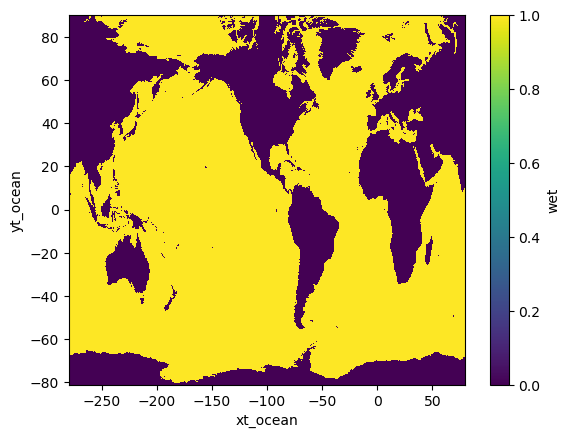

In [6]:
param_hires['wet'].plot()
plt.show()

In [7]:
if data_test==True:
  raw_data = xr.open_zarr('/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/offline_test/cm2p6/forcing.zarr')
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')
else:
  raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr')
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')

In [8]:
raw_datasets

[<xarray.Dataset>
 Dimensions:   (time: 32, yu_ocean: 645, xu_ocean: 900)
 Coordinates:
   * time      (time) object 0181-01-01 12:00:00 ... 0181-02-01 12:00:00
   * xu_ocean  (xu_ocean) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
   * yu_ocean  (yu_ocean) float64 -81.02 -80.86 -80.69 ... 84.53 84.7 84.87
 Data variables:
     S_x       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     S_y       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     usurf     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     vsurf     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
 Attributes:
     filename:   01810101.ocean_minibling_surf_field.nc
     grid_tile:  1
     grid_type:  mosaic
     history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
     title:      CM2.6_miniBling]

In [10]:
low_rez = raw_datasets[0]
u = low_rez['usurf']
v = low_rez['vsurf']
# u = prog['u'].fillna(0)

In [11]:
low_rez.nbytes / 1e9

0.297228616

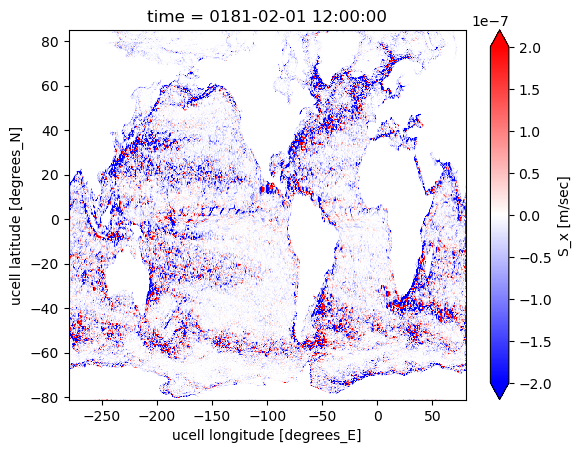

In [12]:
%matplotlib inline
low_rez['S_x'].isel(time=-1).plot(cmap='bwr',vmin=-2*1e-7, vmax = 2*1e-7)
plt.show()

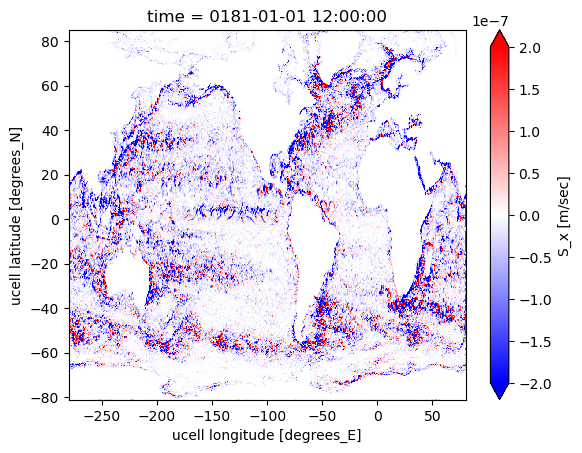

In [13]:
%matplotlib inline
low_rez['S_x'].isel(time=0).plot(cmap='bwr',vmin=-2*1e-7, vmax = 2*1e-7)
plt.show()

In [14]:
import torch
import importlib
from torch.nn import Parameter

replicate = True
mask = True
batch_norm = 1

# GPU setup
args_no_cuda = False #True when manually turn off cuda
use_cuda = not args_no_cuda and torch.cuda.is_available()
if use_cuda:
    print('device for inference on',torch.cuda.device_count(),'GPU(s)')
else:
    print('device for inference on CPU')

#load the neural network
def load_model_cls(model_module_name: str, model_cls_name: str):
    try:
        module = importlib.import_module(model_module_name)
        model_cls = getattr(module, model_cls_name)
    except ModuleNotFoundError as e:
        raise type(e)('Could not retrieve the module in which the trained model \
                      is defined: ' + str(e))
    except AttributeError as e:
        raise type(e)('Could not retrieve the model\'s class. ' + str(e))
    return model_cls
def load_paper_net(device: str = 'gpu'):
    """
        Load the neural network from the paper
    """
    print('In load_paper_net()')
    model_module_name = 'models.models1'
    model_cls_name = 'FullyCNN_BC'
    model_cls = load_model_cls(model_module_name, model_cls_name)
    print('After load_model_cls()')
    net = model_cls(2,4,batch_norm=batch_norm)
    
    # final_transform= '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/final_transformation_04292023.pth'
    # print('After net')
    # if device == 'cpu':
    #     transformation = torch.load(final_transform)
    #     print('After torch.load()')
    # else:
    #     transformation = pickle_artifact(MODEL_RUN_ID, 'models/transformation')
    # net.final_transformation = transformation
    print('After transformation')
    # Load parameters of pre-trained model
    print('After mlflow.tracking.MlflowClient()')
    
    
    # ----------------- CHANGE THIS PATH TO TRAINED MODEL ----------------- #
    model_file = '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/trained_model_global_BC_RP2.pth'
    # ---------------------------------------------------- #
    
    
    print('Loading final transformation')
    model_module_name = 'models.transforms'
    model_cls_name1 = 'SoftPlusTransform'
    model_cls = load_model_cls(model_module_name, model_cls_name1)
    model_cls_name2 = 'PrecisionTransform'
    model_cls1 = load_model_cls(model_module_name, model_cls_name2)
    transform = model_cls.__new__(model_cls,)
    model_cls1.__init__(transform,)
    state_dict = torch.load(model_file, map_location=torch.device('cpu'))
    # print('file:',state_dict.keys())
    # print('net:',net.state_dict().keys())
    transform._min_value = Parameter(state_dict.pop('final_transformation._min_value'))
    transform.indices = slice(2,4)
    print('After download_artifacts()')
    #change the key name->
    print(model_cls_name)
    if model_cls_name.endswith("_BC"):
        from collections import OrderedDict
        if batch_norm == 1:
            keys_to_delete = ['batch_norm1.num_batches_tracked', 'batch_norm2.num_batches_tracked', 'batch_norm3.num_batches_tracked', 'batch_norm4.num_batches_tracked', 'batch_norm5.num_batches_tracked', 'batch_norm6.num_batches_tracked', 'batch_norm7.num_batches_tracked']
            for key in keys_to_delete:
                if key in state_dict:
                    del state_dict[key]
            new_name=["conv1.weight", "conv1.bias", "batch_norm1.weight", "batch_norm1.bias", "batch_norm1.running_mean", "batch_norm1.running_var", "conv2.weight", "conv2.bias", "batch_norm2.weight", "batch_norm2.bias", "batch_norm2.running_mean", "batch_norm2.running_var", "conv3.weight", "conv3.bias", "batch_norm3.weight", "batch_norm3.bias", "batch_norm3.running_mean", "batch_norm3.running_var", "conv4.weight", "conv4.bias", "batch_norm4.weight", "batch_norm4.bias", "batch_norm4.running_mean", "batch_norm4.running_var", "conv5.weight", "conv5.bias", "batch_norm5.weight", "batch_norm5.bias", "batch_norm5.running_mean", "batch_norm5.running_var", "conv6.weight", "conv6.bias", "batch_norm6.weight", "batch_norm6.bias", "batch_norm6.running_mean", "batch_norm6.running_var", "conv7.weight", "conv7.bias", "batch_norm7.weight", "batch_norm7.bias", "batch_norm7.running_mean", "batch_norm7.running_var", "conv8.weight", "conv8.bias"]
        elif batch_norm == 0:
            new_name=["conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "conv5.weight", "conv5.bias", "conv6.weight", "conv6.bias", "conv7.weight", "conv7.bias", "conv8.weight", "conv8.bias"]
        new_state_dict = OrderedDict()
        i=0
        for k, v in state_dict.items():
            name = new_name[i]
            new_state_dict[name] = v
            i = i+1
        state_dict = new_state_dict
        # print(state_dict.keys())
    #<-
    net.load_state_dict(state_dict)
    net.final_transformation = transform
    print(net)
    return net
net = load_paper_net('cpu')
net.eval()
istep = 0
matrix_dict = {}

device for inference on CPU
In load_paper_net()
After load_model_cls()
After transformation
After mlflow.tracking.MlflowClient()
Loading final transformation
After download_artifacts()
FullyCNN_BC
FullyCNN_BC(
  (conv1): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [15]:
device = torch.device('cpu')
from train.losses import HeteroskedasticGaussianLossV2

In [16]:
criterion = HeteroskedasticGaussianLossV2(n_target_channels=2)

In [17]:
from testing.utils_bc import (create_large_test_dataset, create_test_dataset)
from torch.utils.data import DataLoader

In [18]:
if data_test==True:
  from data.datasets import (RawDataFromXrDataset, DatasetTransformer,
                             Subset_, DatasetWithTransform, ComposeTransforms,
                             MultipleTimeIndices, DatasetPartitioner)
  mask=True
  replicate=False
  low_rez = low_rez.fillna(0)
  low_rez = low_rez.isel(time=slice(0, 4))
  dataset = RawDataFromXrDataset(low_rez * 10.)
  dataset.index = 'time'
  dataset.add_input('usurf')
  dataset.add_input('vsurf')
  dataset.add_landmask_input()
  dataset.add_output('S_x')
  dataset.add_output('S_y')
  features_transform_ = ComposeTransforms()
  targets_transform_ = ComposeTransforms()
  transform = DatasetTransformer(features_transform_, targets_transform_)
  transform.fit(dataset)
  dataset = DatasetWithTransform(dataset, transform)
  test1 = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=False, replicate=False)
  test1 = test1.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test2 = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=True, replicate=False)
  test2 = test2.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test3 = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=True, replicate=True)
  test3 = test3.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))

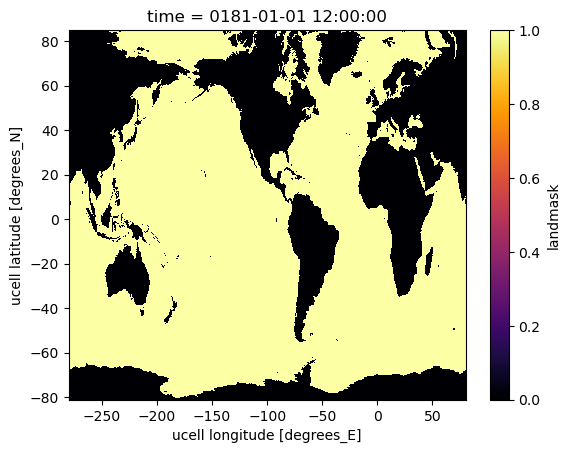

In [19]:
if data_test==True:
  dataset
  dataset.isel(time=0)['landmask'].plot(cmap='inferno')
  plt.show()

In [20]:
if data_test==True:
  from dask.diagnostics import ProgressBar
  with ProgressBar():
      test1 = test1.compute()
      test2 = test2.compute()
      test3 = test2.compute()
else:
   test1 = xr.open_dataset('.nc')

[########################################] | 100% Completed | 5.94 ss
[########################################] | 100% Completed | 14.00 s


In [21]:
def sx_error_plt(test):
    fig, ax = plt.subplots(3, 1, figsize=(12,10))
    plt.rcParams.update({'font.size': 12})
    ax = ax.reshape(-1)
    S_test = test.isel(time=-1)['S_x']*(1e-7)
    S_true = low_rez.isel(time=-1)['S_x']
    error = S_true-S_test
    xq = test['xu_ocean']
    yq = test['yu_ocean']
    
    p = ax[0].imshow(S_true, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    # ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('(a) $S_{x}^{(mean)}$: true forcing')
    
    p = ax[1].imshow(S_test, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    # ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('(b) $S_{x}^{(mean)}$: offline prediction')
    
    p = ax[2].imshow(error, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    ax[2].set_title('(c) Error map')
    
    fig.colorbar(p, ax=ax, label='Subgrid forcing: $ms^{-2}$')
        # plt.savefig('../Paper_figures/figureB_1_1.png', dpi=300, bbox_inches="tight")
    
    # test.isel(time=-10)['S_x'].plot(vmin=-1, vmax=1, cmap='bwr')

In [22]:
def sy_error_plt(test):
    fig, ax = plt.subplots(3, 1, figsize=(12,10))
    plt.rcParams.update({'font.size': 12})
    ax = ax.reshape(-1)
    S_test = test.isel(time=-1)['S_y']*(1e-7)
    S_true = low_rez.isel(time=-1)['S_y']
    error = S_true-S_test
    xq = test['xu_ocean']
    yq = test['yu_ocean']
    
    p = ax[0].imshow(S_true, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    # ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('(d) $S_{y}^{(mean)}$: true forcing')
    
    p = ax[1].imshow(S_test, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    # ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('(e) $S_{y}^{(mean)}$: offline prediction')
    
    p = ax[2].imshow(error, origin='lower',
        extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
        cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    ax[2].set_title('(f) Error map')
    
    fig.colorbar(p, ax=ax, label='Subgrid forcing: $ms^{-2}$')
        # plt.savefig('../Paper_figures/figureB_1_2.png', dpi=300, bbox_inches="tight")
    
    # (low_rez.isel(time=-10)['S_x']*1e7).plot(vmin=-1, vmax=1, cmap='bwr')

In [23]:
S_test = test1.isel(time=-1)['S_x']
# S_test.plot(cmap='inferno')
# plt.show()
S_test

<xarray.DataArray 'S_x' (yu_ocean: 645, xu_ocean: 900)>
array([[-0.00779839, -0.00779839, -0.00779839, ..., -0.00779839,
        -0.00779839, -0.00779839],
       [-0.00779839, -0.00779839, -0.00779839, ..., -0.00779839,
        -0.00779839, -0.00779839],
       [-0.00779839, -0.00779839, -0.00779839, ..., -0.00779839,
        -0.00779839, -0.00779839],
       ...,
       [-0.00779839, -0.00779839, -0.00779839, ..., -0.00779839,
        -0.00779839, -0.00779839],
       [-0.00779839, -0.00779839, -0.00779839, ..., -0.00779839,
        -0.00779839, -0.00779839],
       [-0.00779839, -0.00779839, -0.00779839, ..., -0.00779839,
        -0.00779839, -0.00779839]], dtype=float32)
Coordinates:
    time      object 0181-01-04 12:00:00
  * yu_ocean  (yu_ocean) float64 -81.02 -80.86 -80.69 ... 84.53 84.7 84.87
  * xu_ocean  (xu_ocean) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85

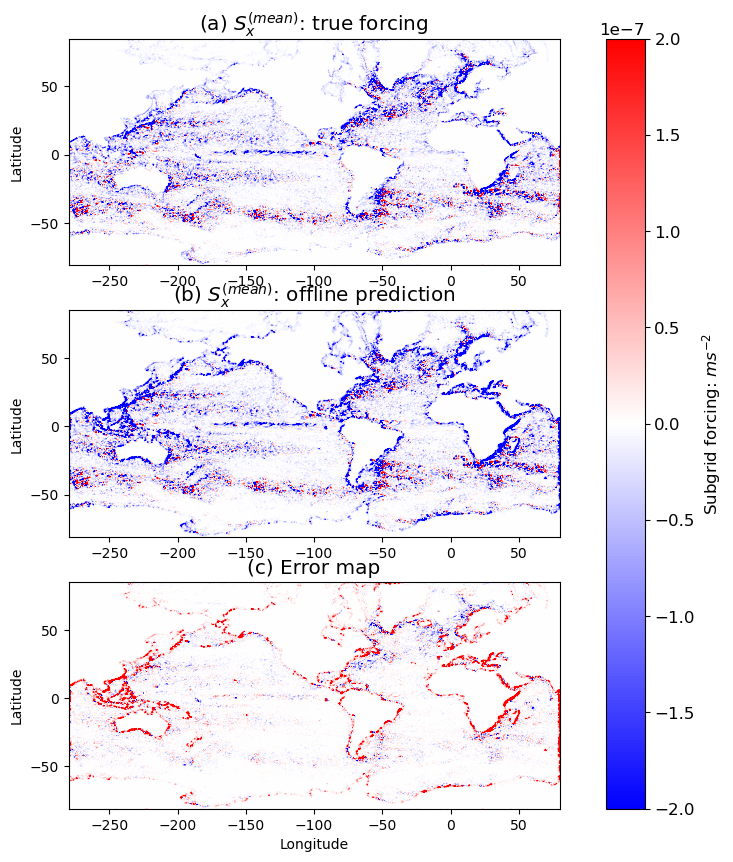

In [24]:
sx_error_plt(test1)

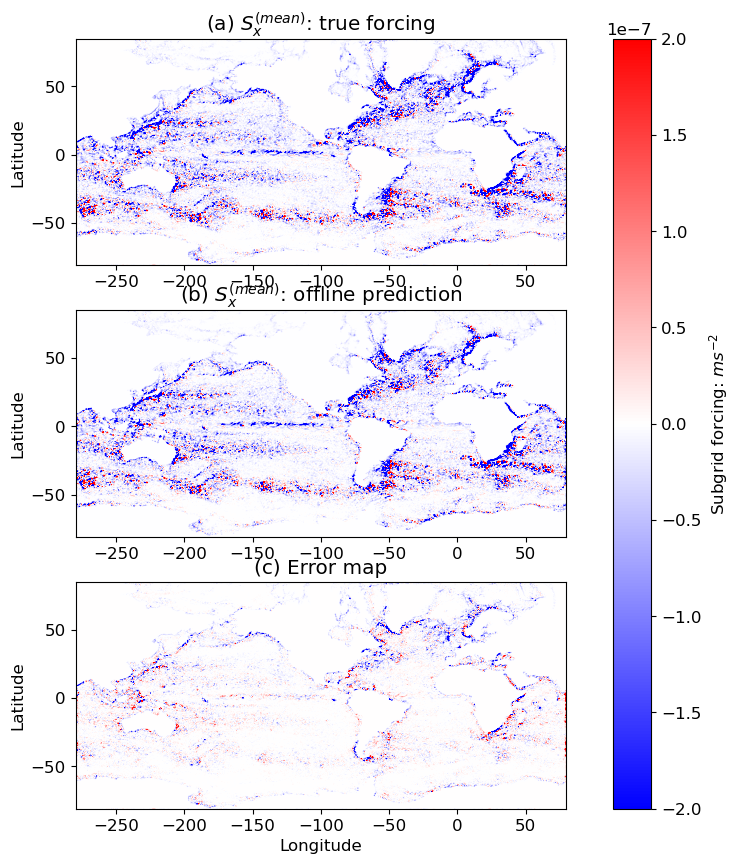

In [25]:
sx_error_plt(test2)

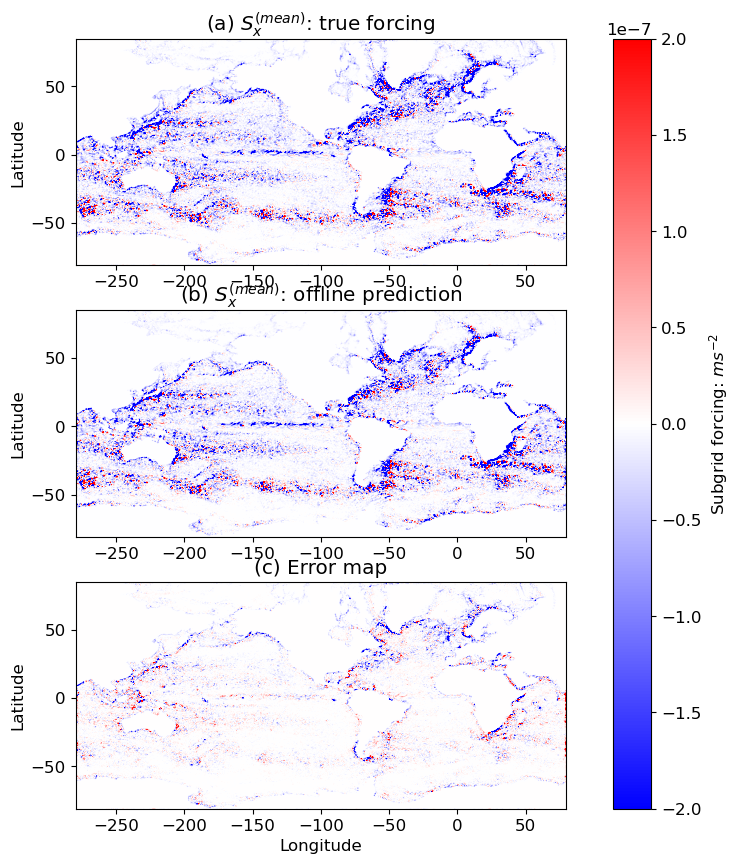

In [26]:
sx_error_plt(test3)

In [27]:
from scipy.stats import norm
def scatter(test):
    plt.figure()
    ((low_rez['S_x']*1e7 - test['S_x'])
     * (test['S_xscale'])).plot.hist(bins=np.linspace(-4, 4, 100), density=True)
    plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)))
    plt.figure()
    for i, var in enumerate(['S_x', 'S_y']):
        residuals_t = ((low_rez[var]*1e7 - test[var]) * (test[f'{var}scale']))
        quantiles = np.linspace(0., 1., 100)
        norm_quantiles = norm.ppf(quantiles)
        obs_quantiles = np.nanquantile(residuals_t.values[::20, ::, ::], quantiles)
        plt.subplot(1, 2, i + 1)
        plt.plot(norm_quantiles, norm_quantiles, 'gray')
        plt.plot(norm_quantiles, obs_quantiles, 'k*')
        plt.ylim(-4, 4)
        plt.yticks(np.arange(-4, 5, 2))

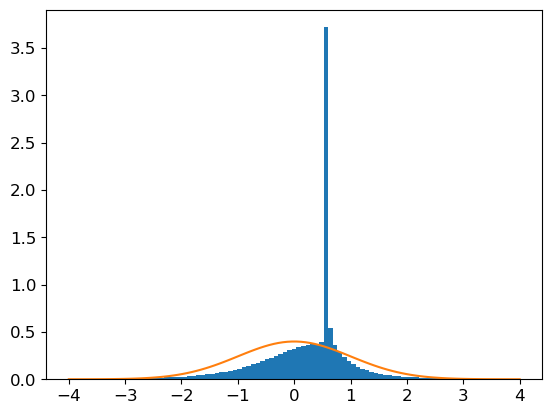

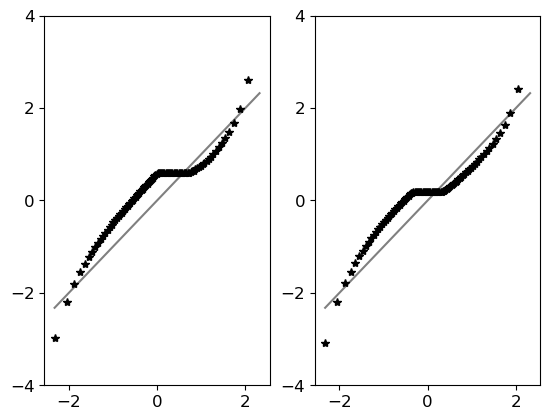

In [28]:
scatter(test1)

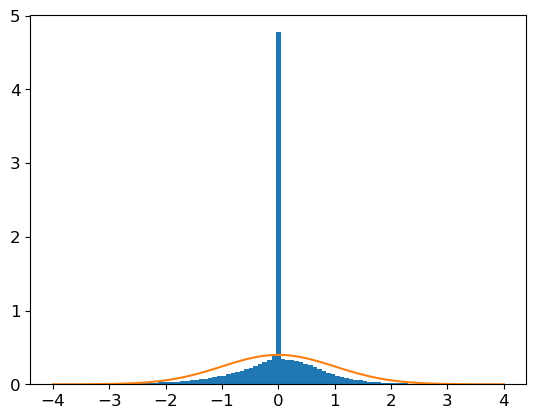

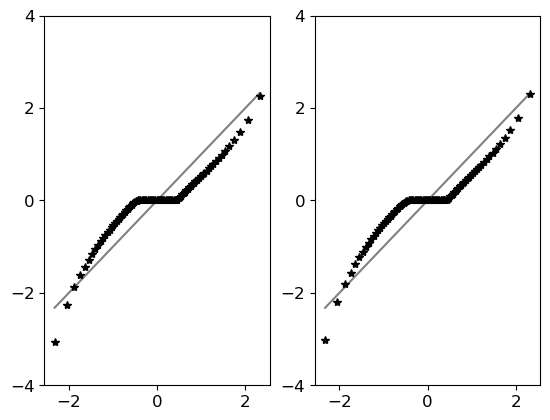

In [29]:
scatter(test2)

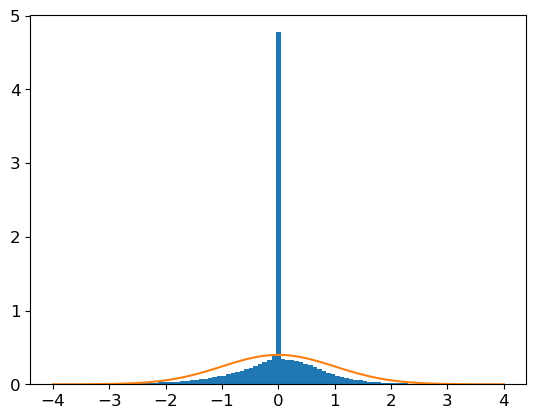

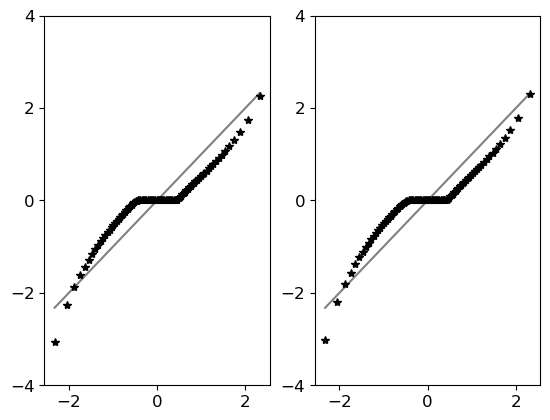

In [30]:
scatter(test3)

In [31]:
# x = low_rez['S_x'].values.flatten()
# x = np.nan_to_num(x, nan=0)
# y = test['S_x'].values.flatten()*1e-7

# plt.scatter(x, y, s=10, alpha=0.5)

# fitcoef = np.polyfit(x, y, 1)
# regression_line = fitcoef[0] * x + fitcoef[1]

# plt.plot(x, regression_line, color='red', label='Linear Regression')

# plt.plot(x, x, linestyle='dashed', color='black', label='y=x')

# plt.xlabel('Sx_true')
# plt.ylabel('Sx_pred')
# plt.legend()

# correlation = np.corrcoef(x, y)[0, 1]
# print(correlation)

# plt.show()

In [32]:
def R2(test):
    mse = dict()
    variance = dict()
    r_squared = dict()
    correlation = dict()
    for var in ['S_x', 'S_y']:
        mse[var] = ((test[var] - low_rez[var]*1e7)**2).mean(dim='time')
        variance[var] = ((low_rez[var]*1e7)**2).mean(dim='time')
        r_squared[var] = 1 - mse[var] / variance[var]
        correlation[var] = xr.corr(test[var], low_rez[var]*1e7, dim='time')
    from matplotlib.patches import Arrow, Circle
    fig = plt.figure(figsize=(12,5))
    plt.rcParams.update({'font.size': 16})
    extent = (low_rez['xu_ocean'].min(), low_rez['xu_ocean'].max(), low_rez['yu_ocean'].min(), low_rez['yu_ocean'].max())
    for i, var in enumerate(['S_x', 'S_y']):
        plt.subplot(1, 2, i + 1)
        im = plt.imshow(r_squared[var].values, vmin=0., vmax=1,
                       origin='lower', extent=extent, aspect="auto")
        
        if i == 0:
            plt.ylabel('Latitude')
            patches = [Circle((11, 40), radius=0.4, color='white'),
                         Circle((18, 40), radius=0.4, color='green'),]
            for patch in patches:
                  im.axes.add_patch(patch)
            plt.title('(a) $R^2$ for $S_{x}^{(mean)}$')
        elif i == 1:
            patches = [Circle((11, 40), radius=0.4, color='white'),
                         Circle((18, 40), radius=0.4, color='green'),]
            for patch in patches:
                  im.axes.add_patch(patch)
            plt.title('(b) $R^2$ for $S_{y}^{(mean)}$')
        plt.xlabel('Longitude')
    
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(im, cax=cbar_ax, label=r'$R^2$')

/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


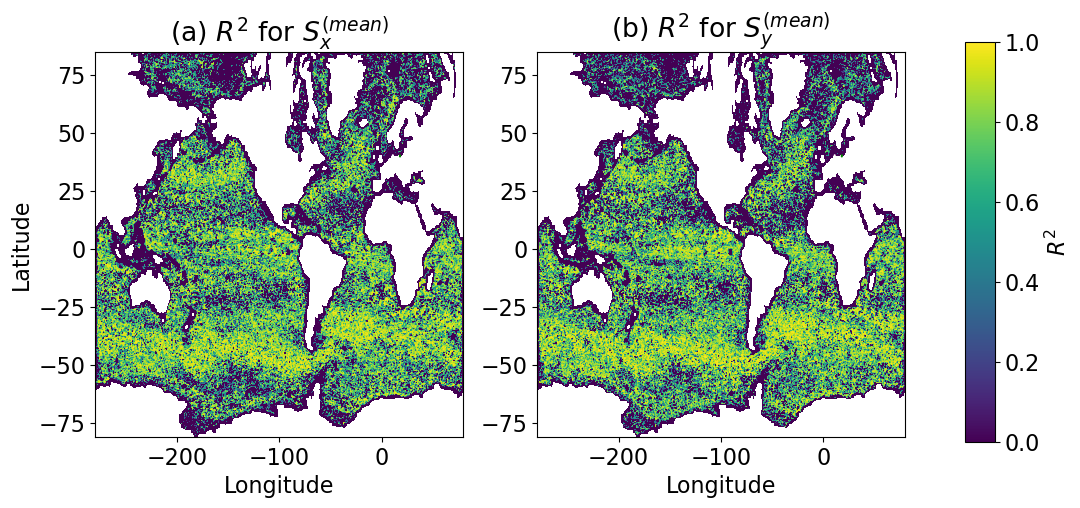

In [33]:
R2(test1)

/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


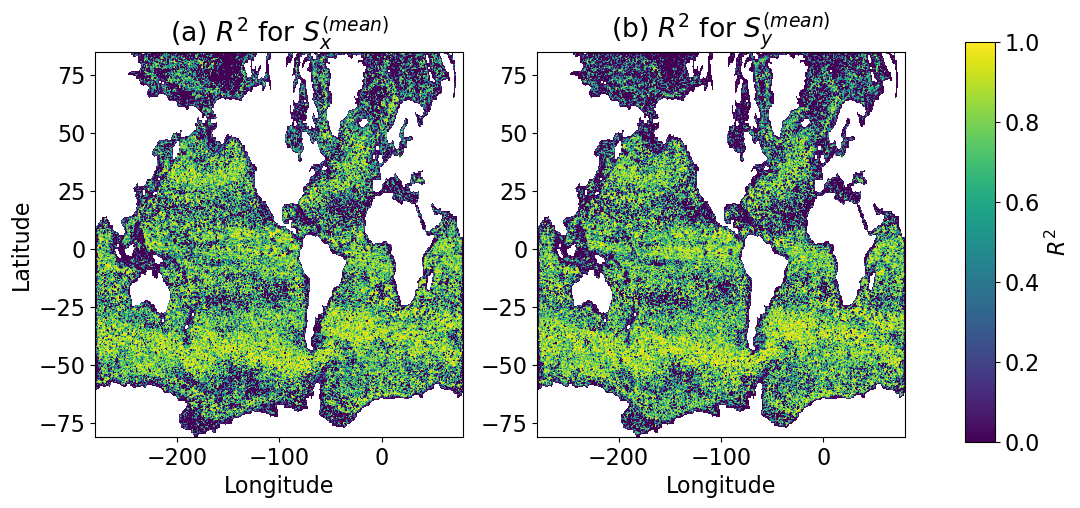

In [34]:
R2(test2)

/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


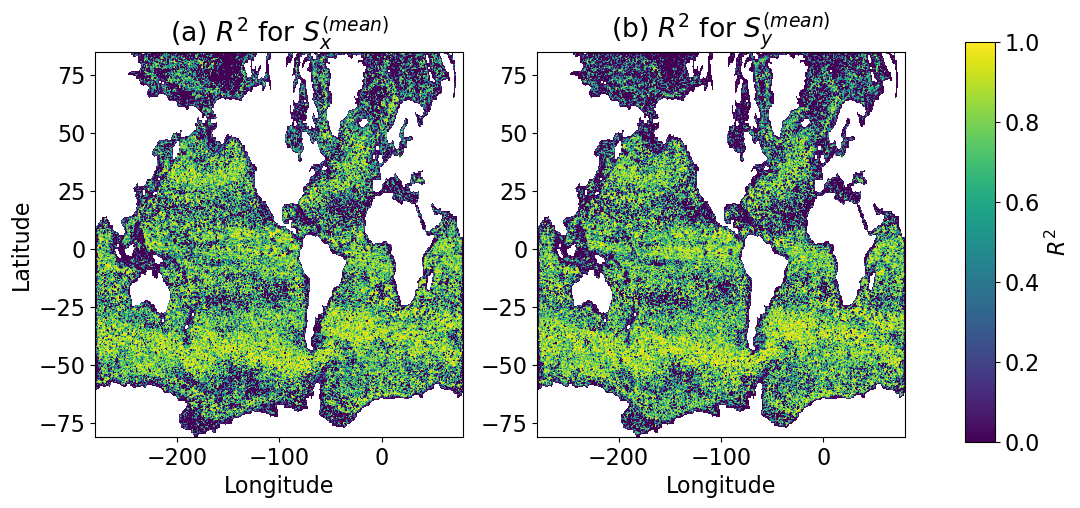

In [35]:
R2(test3)